# BIL 366 Data Mining Final

<br>
<b> Mustafa Kemal GOKCE - 18120205034 </b>

<b>Yusuf YALCIN - 18120205032 </b>


## Proje Amacı
<hr>

Bu projede grup üyeleri haftalık ölüm değerlerini kullanarak covid-19 yoğunluk verisindeki toplu ulaşım kullanım artış yüzdesini sınıflandırmayı amaçlamaktadır. Projede karar verilen problem “predictive”dir. Projede 1 haftalık ölüm verilerini kullanarak haftadaki toplu ulaşım kullanım artış yüzdesi sınıflandırılmıştır.

## Problem Çözümü
<hr>

Problem çözümü aşamasında veri setleri incelendikten sonra KNN kullanılmasına karar verilmiştir. KNN ile kullanılmak üzere 5 sınıf kullanılmasına karar verilmiştir. Bu 5 sınıf değeri Ulaşım Kullanım yüzdesi değerlerinin ortalama aralığına göre ayarlanmıştır.

In [319]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly
import warnings
warnings.filterwarnings('ignore')

Proje kapsamında 3 farklı veri seti kullanılmıştır. Bu veri setleri 2021 yılı Fransa Covid-19 Mobility veri seti, 2021 yılı Almanya Covid-19 Mobility veri seti ve tüm ülkelerin 2020-2022 yılları arasındaki vaka sayısı, ölüm sayısı vb. değerleri içeren owid-covid veri setinden oluşur.

In [320]:
df2021DE = pd.read_csv("2021_DE_Region_Mobility_Report.csv")
owidData = pd.read_csv("owid-covid-data.csv")
df2021FR = pd.read_csv("2021_FR_Region_Mobility_Report.csv")

In [321]:
owidData.columns[:10]

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed'],
      dtype='object')

### 1.Veri Setlerinin Düzenlenmesi

#### 1.1 Fransa Covid Verileri

In [322]:
owidDataFR = owidData[owidData['iso_code'] == 'FRA']
owidDataFR = owidDataFR.loc[:,: 'new_deaths_smoothed']
owidDataFR['date'] =  pd.to_datetime(owidDataFR['date'])
owidDataFR = owidDataFR.set_index(owidDataFR['date'])
owidDataFR = owidDataFR.drop('date', axis=1)

In [323]:
owidDataFR = owidDataFR[(owidDataFR.index >= '2021-01-4') & (owidDataFR.index < '2021-12-27')]

Bu veriler for döngüsü yardımıyla haftalık olarak düzenlenir. 4 Ocak - 27 Aralık tarihleri arasında toplam 51 hafta olduğu için yeni oluşacak DataFrame 51 adet satıra sahiptir. Yeni oluşturalan DataFrame'de önceki haftaya göre artış oranları da "roi" sütunları şeklinde eklenmiştir.

In [324]:
caseList = []
deathList = []
smoothCaseList = []
smoothDeathList = []
rateOfIncreaseCase = [0]
rateOfIncreaseDeath = [0]
rateOfIncreaseCaseSmooth = [0]
rateOfIncreaseDeathSmooth = [0]
for i in range(0,51):
    caseList.append(owidDataFR['new_cases'].iloc[i* 7:i* 7 + 7].sum())
    deathList.append(owidDataFR['new_deaths'].iloc[i* 7:i* 7 + 7].sum())
    smoothCaseList.append(owidDataFR['new_cases_smoothed'].iloc[i* 7:i* 7 + 7].sum())
    smoothDeathList.append(owidDataFR['new_deaths_smoothed'].iloc[i* 7:i* 7 + 7].sum())
    if i >0:
        rateOfIncreaseCase.append((caseList[i] - caseList[i-1]) / caseList[i-1] )
        rateOfIncreaseDeath.append((deathList[i] - deathList[i-1]) / deathList[i-1] )
        rateOfIncreaseCaseSmooth.append((smoothCaseList[i] - smoothCaseList[i-1]) / smoothCaseList[i-1] )
        rateOfIncreaseDeathSmooth.append((smoothDeathList[i] - smoothDeathList[i-1]) / smoothDeathList[i-1] )


weeklyDataFR = pd.DataFrame(data = np.array([caseList, rateOfIncreaseCase, smoothCaseList, rateOfIncreaseCaseSmooth, deathList, rateOfIncreaseDeath, smoothDeathList, rateOfIncreaseDeathSmooth]).T, columns= ['new_cases', 'new_cases_roi', 'new_cases_smoothed', 'new_cases_smoothed_roi' , 'new_deaths', 'new_deaths_roi', 'new_deaths_smoothed', 'new_deaths_smoothed_roi'])

for i in range(0,4):
    weeklyDataFR.iloc[0,2*i + 1] = weeklyDataFR.iloc[1:,2*i + 1].mean()

In [325]:
weeklyDataFR.head()

,new_cases,new_cases_roi,new_cases_smoothed,new_cases_smoothed_roi,new_deaths,new_deaths_roi,new_deaths_smoothed,new_deaths_smoothed_roi
0,127536.0,0.073385,110657.858,0.073406,2713.0,0.008167,2422.999,0.007133
1,127810.0,0.002148,126222.143,0.140652,2533.0,-0.066347,2528.000,0.043335
2,142925.0,0.118261,136281.999,0.079700,2766.0,0.091986,2667.286,0.055097
3,143598.0,0.004709,142635.143,0.046618,3008.0,0.087491,2877.857,0.078946
4,139934.0,-0.025516,139456.857,-0.022283,2908.0,-0.033245,2986.573,0.037777


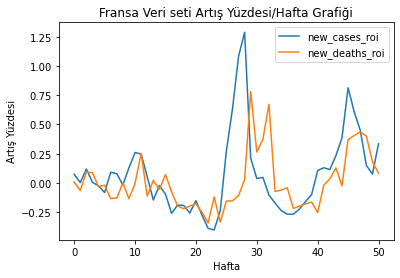

In [326]:
weeklyDataFR.new_cases_roi.plot(label = 'new_cases_roi')
weeklyDataFR.new_deaths_roi.plot(label = 'new_deaths_roi')
plt.title('Fransa Veri seti Artış Yüzdesi/Hafta Grafiği')
plt.xlabel('Hafta')
plt.ylabel('Artış Yüzdesi')
plt.legend()
plt.show()

#### 1.2 Almanya Covid Verileri

In [327]:
owidDataDE = owidData[owidData['iso_code'] == 'DEU']
owidDataDE = owidDataDE.loc[:,: 'new_deaths_smoothed']
owidDataDE['date'] =  pd.to_datetime(owidDataDE['date'])
owidDataDE = owidDataDE.set_index(owidDataDE['date'])
owidDataDE = owidDataDE.drop('date', axis=1)


In [328]:
owidDataDE = owidDataDE[(owidDataDE.index >= '2021-01-4') & (owidDataDE.index < '2021-12-27')]

Bu veriler for döngüsü yardımıyla haftalık olarak düzenlenir. 4 Ocak - 27 Aralık tarihleri arasında toplam 51 hafta olduğu için yeni oluşacak DataFrame 51 adet satıra sahiptir. Yeni oluşturalan DataFrame'de önceki haftaya göre artış oranları da "roi" sütunları şeklinde eklenmiştir.

In [329]:
caseList = []
deathList = []
smoothCaseList = []
smoothDeathList = []
rateOfIncreaseCase = [0]
rateOfIncreaseDeath = [0]
rateOfIncreaseCaseSmooth = [0]
rateOfIncreaseDeathSmooth = [0]
for i in range(0,51):
    caseList.append(owidDataDE['new_cases'].iloc[i* 7:i* 7 + 7].sum())
    deathList.append(owidDataDE['new_deaths'].iloc[i* 7:i* 7 + 7].sum())
    smoothCaseList.append(owidDataDE['new_cases_smoothed'].iloc[i* 7:i* 7 + 7].sum())
    smoothDeathList.append(owidDataDE['new_deaths_smoothed'].iloc[i* 7:i* 7 + 7].sum())
    if i >0:
        rateOfIncreaseCase.append((caseList[i] - caseList[i-1]) / caseList[i-1] )
        rateOfIncreaseDeath.append((deathList[i] - deathList[i-1]) / deathList[i-1] )
        rateOfIncreaseCaseSmooth.append((smoothCaseList[i] - smoothCaseList[i-1]) / smoothCaseList[i-1] )
        rateOfIncreaseDeathSmooth.append((smoothDeathList[i] - smoothDeathList[i-1]) / smoothDeathList[i-1] )


weeklyDataDE = pd.DataFrame(data = np.array([caseList, rateOfIncreaseCase, smoothCaseList, rateOfIncreaseCaseSmooth, deathList, rateOfIncreaseDeath, smoothDeathList, rateOfIncreaseDeathSmooth]).T, columns= ['new_cases', 'new_cases_roi', 'new_cases_smoothed', 'new_cases_smoothed_roi' , 'new_deaths', 'new_deaths_roi', 'new_deaths_smoothed', 'new_deaths_smoothed_roi'])

for i in range(0,4):
    weeklyDataDE.iloc[0,2*i + 1] = weeklyDataDE.iloc[1:,2*i + 1].mean()



In [330]:
weeklyDataDE.head()

,new_cases,new_cases_roi,new_cases_smoothed,new_cases_smoothed_roi,new_deaths,new_deaths_roi,new_deaths_smoothed,new_deaths_smoothed_roi
0,145514.0,0.045551,135302.429,0.048628,6145.0,0.001853,5282.999,0.005027
1,120719.0,-0.170396,132727.286,-0.019032,5965.0,-0.029292,6025.572,0.140559
2,97640.0,-0.191180,102865.714,-0.224984,5395.0,-0.095557,5709.570,-0.052443
3,77890.0,-0.202274,85667.429,-0.167192,4867.0,-0.097868,4950.430,-0.132959
4,66014.0,-0.152471,70361.142,-0.178671,4545.0,-0.066160,4908.999,-0.008369


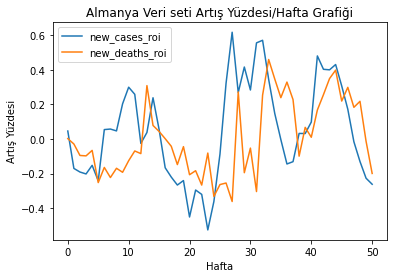

In [331]:
weeklyDataDE.new_cases_roi.plot(label = 'new_cases_roi')
weeklyDataDE.new_deaths_roi.plot(label = 'new_deaths_roi')
plt.title('Almanya Veri seti Artış Yüzdesi/Hafta Grafiği')
plt.xlabel('Hafta')
plt.ylabel('Artış Yüzdesi')
plt.legend()
plt.show()

#### 1.3 Fransa İçin Region_Mobility_Report Verilerinin Düzenlenmesi 

In [332]:
df2021FR = df2021FR[pd.isnull(df2021FR['sub_region_1'])]

In [333]:
df2021FR['date'] =  pd.to_datetime(df2021FR['date'])
df2021FR = df2021FR.set_index(df2021FR['date'])

In [334]:
df2021FR = df2021FR.loc[:, 'retail_and_recreation_percent_change_from_baseline':]

In [335]:
df2021FR = df2021FR[(df2021FR.index >= '2021-01-4') & (df2021FR.index < '2021-12-27')]

#### 1.3.1 Günlük Verilerin Haftalık Verilere Çevrilmesi

In [336]:
emptyArray = np.zeros([6, 51])

for j in range(0,6):
    x = []
    for i in range(0, 51):
        x.append(df2021FR.iloc[i * 7:i* 7 + 7,j].mean())
    x = np.array(x) 
    emptyArray[j] = x
 
weeklydf2021FR = pd.DataFrame(data= emptyArray.T, columns= df2021FR.columns)

In [337]:
weeklydf2021FR = pd.concat([weeklyDataFR, weeklydf2021FR], axis=1)

In [338]:
weeklydf2021FR.head()

,new_cases,new_cases_roi,new_cases_smoothed,new_cases_smoothed_roi,new_deaths,new_deaths_roi,new_deaths_smoothed,new_deaths_smoothed_roi,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,127536.0,0.073385,110657.858,0.073406,2713.0,0.008167,2422.999,0.007133,-39.000000,-2.714286,-21.714286,-34.285714,-22.857143,10.142857
1,127810.0,0.002148,126222.143,0.140652,2533.0,-0.066347,2528.000,0.043335,-43.428571,-10.285714,-24.000000,-36.285714,-24.571429,9.285714
2,142925.0,0.118261,136281.999,0.079700,2766.0,0.091986,2667.286,0.055097,-42.428571,-11.142857,-24.285714,-36.428571,-24.142857,9.142857
3,143598.0,0.004709,142635.143,0.046618,3008.0,0.087491,2877.857,0.078946,-40.714286,-8.714286,-20.000000,-34.000000,-23.714286,8.857143
4,139934.0,-0.025516,139456.857,-0.022283,2908.0,-0.033245,2986.573,0.037777,-43.857143,-9.000000,-16.714286,-34.714286,-23.857143,9.142857


#### 1.4 Almanya İçin Region_Mobility_Report Verilerinin Düzenlenmesi 

In [339]:
df2021DE = df2021DE[pd.isnull(df2021DE['sub_region_1'])]


In [340]:
df2021DE['date'] =  pd.to_datetime(df2021DE['date'])
df2021DE = df2021DE.set_index(df2021DE['date'])

In [341]:
df2021DE = df2021DE.loc[:, 'retail_and_recreation_percent_change_from_baseline':]

In [342]:
df2021DE = df2021DE[(df2021DE.index >= '2021-01-4') & (df2021DE.index < '2021-12-27')]

#### 1.4.1 Günlük Verilerin Haftalık Verilere Çevrilmesi

In [343]:
emptyArray = np.zeros([6, 51])

for j in range(0,6):
    x = []
    for i in range(0, 51):
        x.append(df2021DE.iloc[i * 7:i* 7 + 7,j].mean())
    x = np.array(x) 
    emptyArray[j] = x
   
weeklydf2021DE = pd.DataFrame(data= emptyArray.T, columns= df2021DE.columns)


In [344]:
weeklydf2021DE = pd.concat([weeklyDataDE, weeklydf2021DE], axis=1)

In [345]:
weeklydf2021DE.head()

,new_cases,new_cases_roi,new_cases_smoothed,new_cases_smoothed_roi,new_deaths,new_deaths_roi,new_deaths_smoothed,new_deaths_smoothed_roi,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,145514.0,0.045551,135302.429,0.048628,6145.0,0.001853,5282.999,0.005027,-60.142857,-15.428571,-7.000000,-50.142857,-35.714286,14.714286
1,120719.0,-0.170396,132727.286,-0.019032,5965.0,-0.029292,6025.572,0.140559,-60.142857,-15.285714,-11.714286,-48.285714,-28.285714,12.285714
2,97640.0,-0.191180,102865.714,-0.224984,5395.0,-0.095557,5709.570,-0.052443,-59.571429,-15.714286,-10.714286,-48.571429,-28.428571,12.142857
3,77890.0,-0.202274,85667.429,-0.167192,4867.0,-0.097868,4950.430,-0.132959,-58.142857,-13.285714,-5.000000,-46.571429,-27.857143,12.142857
4,66014.0,-0.152471,70361.142,-0.178671,4545.0,-0.066160,4908.999,-0.008369,-58.142857,-12.857143,-12.714286,-48.571429,-28.571429,12.000000


#### 1.5 İstenilen Haftalık Verinin Görselleştirilmesi

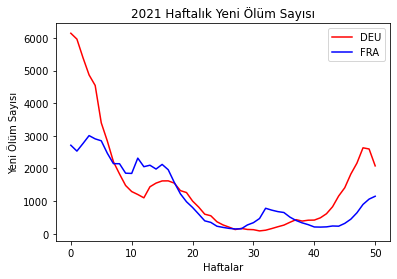

In [346]:
plt.plot(weeklydf2021DE.new_deaths, color ='red', label = 'DEU')
plt.plot(weeklydf2021FR.new_deaths, color ='blue',label = 'FRA')
plt.title('2021 Haftalık Yeni Ölüm Sayısı')
plt.xlabel('Haftalar')
plt.ylabel('Yeni Ölüm Sayısı')
plt.legend()
plt.show()

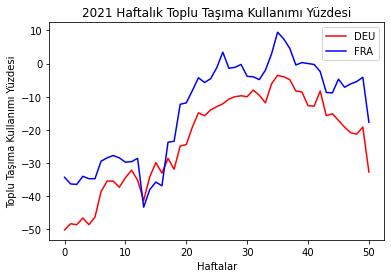

In [347]:
plt.plot(weeklydf2021DE.transit_stations_percent_change_from_baseline, color = 'red', label = 'DEU')
plt.plot(weeklydf2021FR.transit_stations_percent_change_from_baseline, color = 'blue', label = 'FRA')
plt.title('2021 Haftalık Toplu Taşıma Kullanımı Yüzdesi')
plt.xlabel('Haftalar')
plt.ylabel('Toplu Taşıma Kullanımı Yüzdesi')
plt.legend()
plt.show()

<h3> 2. Veriler Arasındaki İlişki </h3>

#### 2.1 Almanya Verileri Arasındaki İlişki


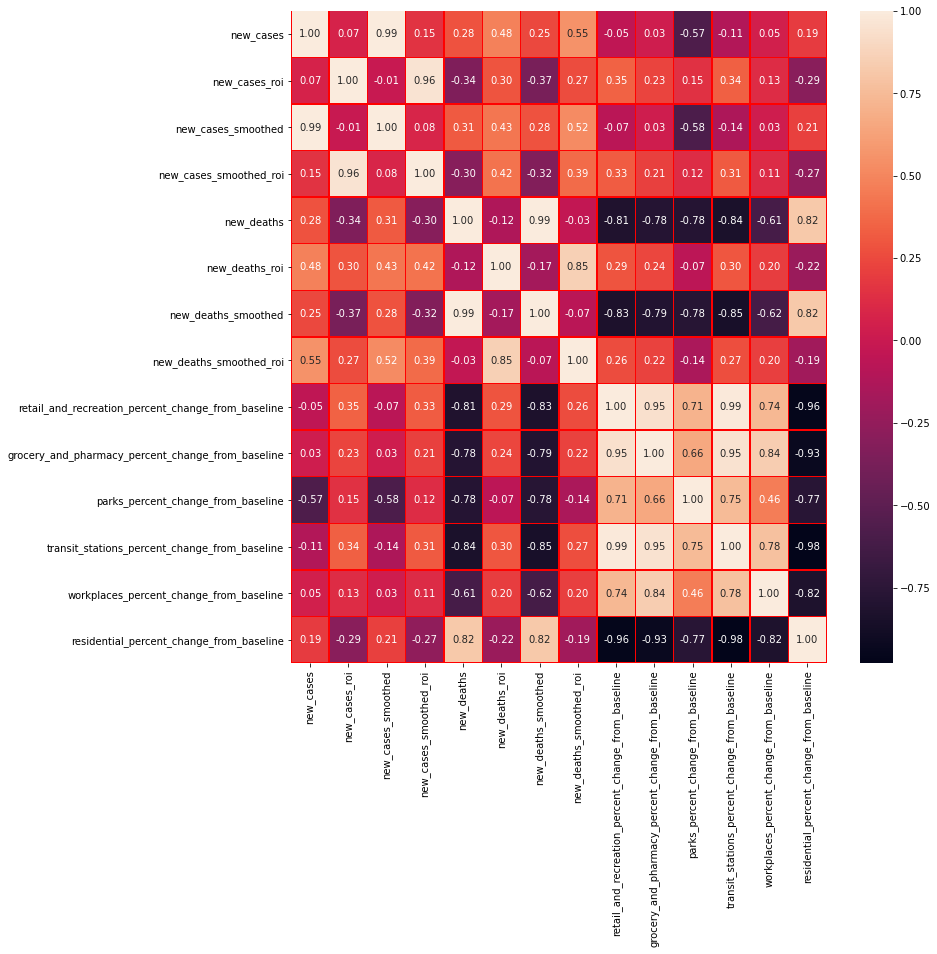

In [348]:
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(weeklydf2021DE.corr(), annot=True, linewidths=0.5,linecolor="red", fmt= '.2f',ax=ax)
plt.show()

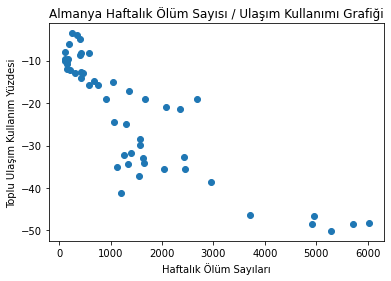

In [349]:
plt.scatter(weeklydf2021DE['new_deaths_smoothed'], weeklydf2021DE['transit_stations_percent_change_from_baseline'] )
plt.title('Almanya Haftalık Ölüm Sayısı / Ulaşım Kullanımı Grafiği')
plt.xlabel('Haftalık Ölüm Sayıları')
plt.ylabel('Toplu Ulaşım Kullanım Yüzdesi')
plt.show()

#### Fransa Verileri Arasındaki İlişki

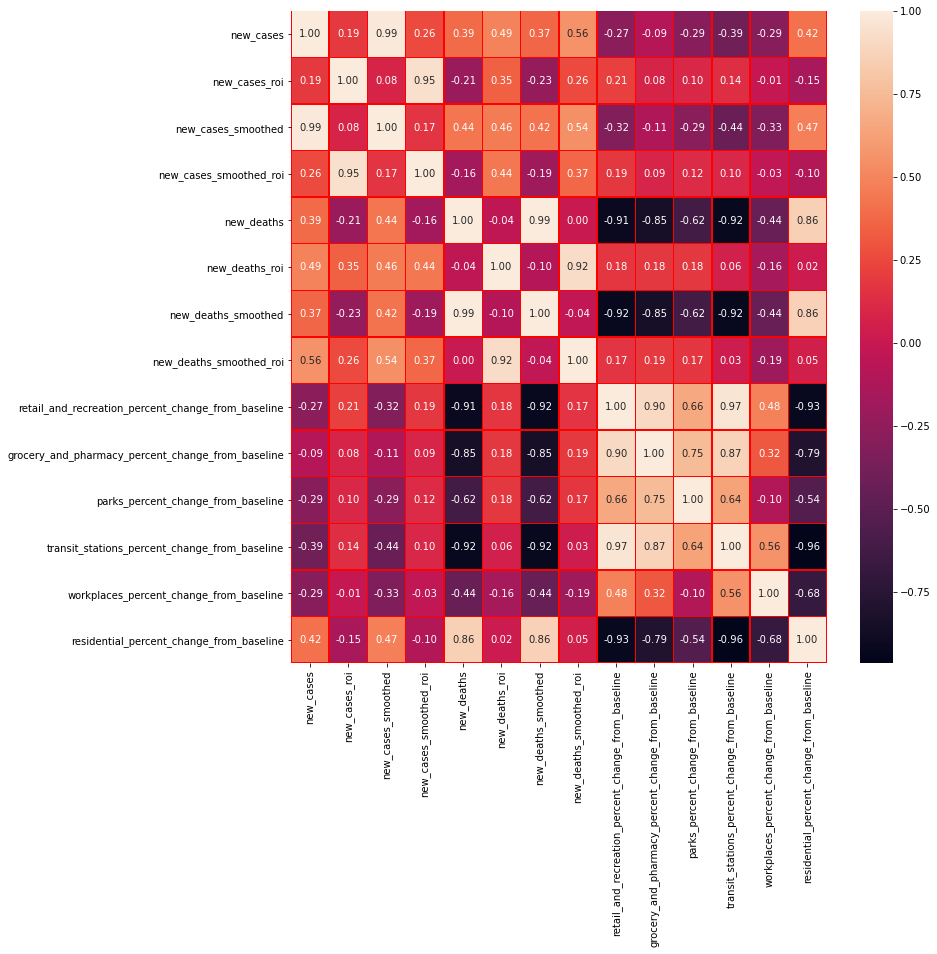

In [350]:
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(weeklydf2021FR.corr(), annot=True, linewidths=0.5,linecolor="red", fmt= '.2f',ax=ax)
plt.show()

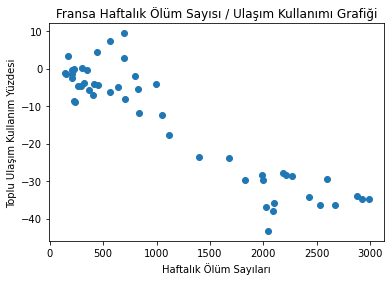

In [351]:
plt.scatter(weeklydf2021FR['new_deaths_smoothed'], weeklydf2021FR['transit_stations_percent_change_from_baseline'] )
plt.title('Fransa Haftalık Ölüm Sayısı / Ulaşım Kullanımı Grafiği')
plt.xlabel('Haftalık Ölüm Sayıları')
plt.ylabel('Toplu Ulaşım Kullanım Yüzdesi')
plt.show()

Toplu taşıma istasyonları ve yeni ölüm verileri arasinda region_mobility_report verisindekilere göre en yüksek negatif korelasyon vardir. Bu yüzden yapılacak tahminlerde toplu taşıma istasyonları kullanılmasına karar verilmiştir. 

## Uygulanan Yöntem
<hr>

Projede kullanılan sınıf sayısı ve veri sayısının az olması ve kolay kullanılabilir olmasından dolayı KNN algoritmasının uygulanmasına karar verildi. KNN algoritmasında kullanılan sınıf sayısı 5'tir. Bu sınıflar artış miktarına göre belirlenir. Artış miktarı 5 farklı değere göre ayarlanır. Bu sınıfların hangi aralıklarda oldukları aşağıda açıklanmıştır.

#### 3. Veriyi KNN En Yakın Komşu Algoritmasına Hazırlama 

#### 3.1 Fransa Verilerini Hazırlama

In [352]:
weeklydf2021FR['how_much_decreased'] = pd.Series(weeklydf2021FR.transit_stations_percent_change_from_baseline.values, index=weeklydf2021FR.index)

Veriler -12'den kucukse 1 sinif degeri

-12 ve -22 arasindaysa 2

-22 ve -32 arasindaysa 3 

-32 ve -42 arasindayda 4 

-42 den kucukse 5 degerini alirlar.

In [353]:
i = 0
for each in weeklydf2021FR.how_much_decreased:
    if each > -12:
        weeklydf2021FR.how_much_decreased.values[i] = 1
    elif each <= -12 and each > -22:
        weeklydf2021FR.how_much_decreased.values[i] = 2
    elif each <= -22 and each > -32:
        weeklydf2021FR.how_much_decreased.values[i] = 3
    elif each <= -32 and each > -42:
        weeklydf2021FR.how_much_decreased.values[i] = 4      
    elif each <= -42:
        weeklydf2021FR.how_much_decreased.values[i] = 5
    i += 1   



In [354]:
weeklydf2021FR.head()

,new_cases,new_cases_roi,new_cases_smoothed,new_cases_smoothed_roi,new_deaths,new_deaths_roi,new_deaths_smoothed,new_deaths_smoothed_roi,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,how_much_decreased
0,127536.0,0.073385,110657.858,0.073406,2713.0,0.008167,2422.999,0.007133,-39.000000,-2.714286,-21.714286,-34.285714,-22.857143,10.142857,4.0
1,127810.0,0.002148,126222.143,0.140652,2533.0,-0.066347,2528.000,0.043335,-43.428571,-10.285714,-24.000000,-36.285714,-24.571429,9.285714,4.0
2,142925.0,0.118261,136281.999,0.079700,2766.0,0.091986,2667.286,0.055097,-42.428571,-11.142857,-24.285714,-36.428571,-24.142857,9.142857,4.0
3,143598.0,0.004709,142635.143,0.046618,3008.0,0.087491,2877.857,0.078946,-40.714286,-8.714286,-20.000000,-34.000000,-23.714286,8.857143,4.0
4,139934.0,-0.025516,139456.857,-0.022283,2908.0,-0.033245,2986.573,0.037777,-43.857143,-9.000000,-16.714286,-34.714286,-23.857143,9.142857,4.0


#### 3.2 Almanya Verilerini Hazırlama

In [355]:
weeklydf2021DE['how_much_decreased'] = pd.Series(weeklydf2021DE.transit_stations_percent_change_from_baseline.values, index=weeklydf2021DE.index)

In [356]:
i = 0
for each in weeklydf2021DE.how_much_decreased:
    if each > -12:
        weeklydf2021DE.how_much_decreased.values[i] = 1
    elif each <= -12 and each > -22:
        weeklydf2021DE.how_much_decreased.values[i] = 2
    elif each <= -22 and each > -32:
        weeklydf2021DE.how_much_decreased.values[i] = 3
    elif each <= -32 and each > -42:
        weeklydf2021DE.how_much_decreased.values[i] = 4      
    elif each <= -42:
        weeklydf2021DE.how_much_decreased.values[i] = 5
    i += 1           

In [357]:
weeklydf2021DE.head()

,new_cases,new_cases_roi,new_cases_smoothed,new_cases_smoothed_roi,new_deaths,new_deaths_roi,new_deaths_smoothed,new_deaths_smoothed_roi,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,how_much_decreased
0,145514.0,0.045551,135302.429,0.048628,6145.0,0.001853,5282.999,0.005027,-60.142857,-15.428571,-7.000000,-50.142857,-35.714286,14.714286,5.0
1,120719.0,-0.170396,132727.286,-0.019032,5965.0,-0.029292,6025.572,0.140559,-60.142857,-15.285714,-11.714286,-48.285714,-28.285714,12.285714,5.0
2,97640.0,-0.191180,102865.714,-0.224984,5395.0,-0.095557,5709.570,-0.052443,-59.571429,-15.714286,-10.714286,-48.571429,-28.428571,12.142857,5.0
3,77890.0,-0.202274,85667.429,-0.167192,4867.0,-0.097868,4950.430,-0.132959,-58.142857,-13.285714,-5.000000,-46.571429,-27.857143,12.142857,5.0
4,66014.0,-0.152471,70361.142,-0.178671,4545.0,-0.066160,4908.999,-0.008369,-58.142857,-12.857143,-12.714286,-48.571429,-28.571429,12.000000,5.0


#### 3.3 Almanya ve Fransa Verilerindeki Sınıf Dağılımlarını Görselleştirme

Aşağıdaki grafiklerde Almanya ve Fransa verilerindeki sınıf dağılımlarını görselleştirilmiştir.

In [358]:
# prepare data frames
bes = weeklydf2021DE[weeklydf2021DE.how_much_decreased == 5]
dort = weeklydf2021DE[weeklydf2021DE.how_much_decreased == 4]
uc = weeklydf2021DE[weeklydf2021DE.how_much_decreased == 3]
iki = weeklydf2021DE[weeklydf2021DE.how_much_decreased == 2]
bir = weeklydf2021DE[weeklydf2021DE.how_much_decreased == 1]

# import graph objects as "go"
import plotly.graph_objs as go
# creating trace1
trace1 =go.Scatter(
                    x = bir.new_deaths_smoothed,
                    y = bir.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "Bir",
                    marker = dict(color = 'rgba(0, 255, 20, 0.8)'),
                    text= weeklydf2021DE.how_much_decreased)
# creating trace2
trace2 =go.Scatter(
                    x = iki.new_deaths_smoothed,
                    y = iki.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "İki",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= weeklydf2021DE.how_much_decreased)
# creating trace3
trace3 =go.Scatter(
                    x = uc.new_deaths_smoothed,
                    y = uc.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "Üç",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= weeklydf2021DE.how_much_decreased)
# creating trace4
trace4 =go.Scatter(
                    x = dort.new_deaths_smoothed,
                    y = dort.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "Dört",
                    marker = dict(color = 'rgba(255, 12, 2, 0.8)'),
                    text= weeklydf2021DE.how_much_decreased)
# creating trace5
trace5 =go.Scatter(
                    x = bes.new_deaths_smoothed,
                    y = bes.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "Beş",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= weeklydf2021DE.how_much_decreased)

data = [trace1, trace2, trace3, trace4, trace5]
layout = dict(title = 'Almanya Haftalık Ölüm Sayısı / Ulaşım Kullanımı Sınıflandırma Grafiği',
              xaxis= dict(title= 'Haftalık Ölüm',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Toplu Ulaşım Kullanım Yüzdesi',ticklen= 5,zeroline= False),
              height=450, width=750
             )
fig = dict(data = data, layout = layout)

In [359]:
# prepare data frames
bes = weeklydf2021FR[weeklydf2021FR.how_much_decreased == 5]
dort = weeklydf2021FR[weeklydf2021FR.how_much_decreased == 4]
uc = weeklydf2021FR[weeklydf2021FR.how_much_decreased == 3]
iki = weeklydf2021FR[weeklydf2021FR.how_much_decreased == 2]
bir = weeklydf2021FR[weeklydf2021FR.how_much_decreased == 1]

# import graph objects as "go"
import plotly.graph_objs as go
# creating trace1
trace1 =go.Scatter(
                    x = bir.new_deaths_smoothed,
                    y = bir.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "Bir",
                    marker = dict(color = 'rgba(0, 255, 20, 0.8)'),
                    text= weeklydf2021FR.how_much_decreased)
# creating trace2
trace2 =go.Scatter(
                    x = iki.new_deaths_smoothed,
                    y = iki.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "İki",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= weeklydf2021FR.how_much_decreased)
# creating trace3
trace3 =go.Scatter(
                    x = uc.new_deaths_smoothed,
                    y = uc.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "Üç",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= weeklydf2021FR.how_much_decreased)
# creating trace4
trace4 =go.Scatter(
                    x = dort.new_deaths_smoothed,
                    y = dort.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "Dört",
                    marker = dict(color = 'rgba(255, 12, 2, 0.8)'),
                    text= weeklydf2021FR.how_much_decreased)
# creating trace5
trace5 =go.Scatter(
                    x = bes.new_deaths_smoothed,
                    y = bes.transit_stations_percent_change_from_baseline,
                    mode = "markers",
                    name = "Beş",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= weeklydf2021FR.how_much_decreased)

data = [trace1, trace2, trace3, trace4, trace5]
layout = dict(title = 'Fransa Haftalık Ölüm Sayısı / Ulaşım Kullanımı Sınıflandırma Grafiği',
              xaxis= dict(title= 'Haftalık Ölüm',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Toplu Ulaşım Kullanım Yüzdesi',ticklen= 5,zeroline= False),
              height=450, width=750
             )
fig2 = dict(data = data, layout = layout)

In [360]:
#Plotly html'de gözükmediği için ayrıca resimlerini ekledik.
#plotly.offline.iplot(fig)
#plotly.offline.iplot(fig2)

<img src="newplot.png" align = "left" >

<img src="newplot2.png" align = "left" >

Aşağıdaki grafiklerde Almanya ve Fransa Mobility verilerindeki sınıf dağılımlarının histogram grafikleri gösterilmiştir.

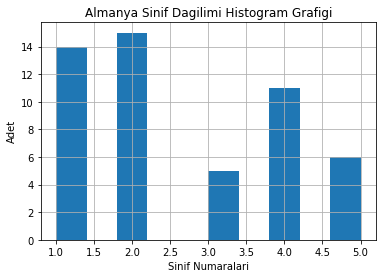

In [361]:
weeklydf2021DE['how_much_decreased'].hist()
plt.title('Almanya Sinif Dagilimi Histogram Grafigi')
plt.xlabel('Sinif Numaralari')
plt.ylabel('Adet')
plt.show()

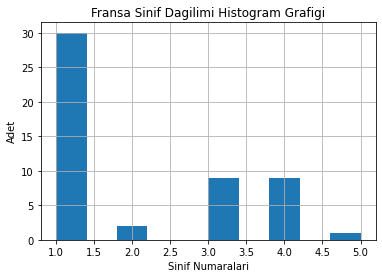

In [362]:
weeklydf2021FR['how_much_decreased'].hist()
plt.title('Fransa Sinif Dagilimi Histogram Grafigi')
plt.xlabel('Sinif Numaralari')
plt.ylabel('Adet')
plt.show()

### 4. KNN İşlemi 

#### 4.1 Eğitim ve Test Olarak Veriyi Ayırmak

In [363]:
X = np.concatenate([weeklydf2021DE.iloc[:, [6]].values,weeklydf2021FR.iloc[:, [6]].values] )
y = np.concatenate([weeklydf2021DE.iloc[:, 14].values,weeklydf2021FR.iloc[:, 14].values ])

In [364]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 0)

#### 4.2 Test Seti ile Tahmin Yapma

In [365]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)

In [366]:
print(" {} nn score: {} ".format(5,knn.score(X_test,y_test)))

 5 nn score: 0.7352941176470589 


#### 4.3 Optimum k Değeri Bulma

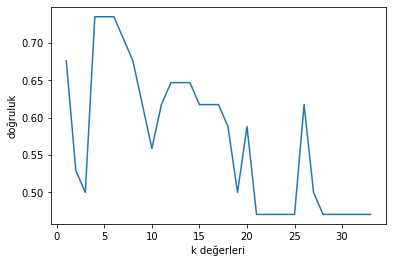

In [367]:
score_list = []
for each in range(1,34):
    knn2 = KNeighborsClassifier(n_neighbors = each)
    knn2.fit(X_train,y_train)
    score_list.append(knn2.score(X_test,y_test))

#print(score_list)
plt.plot(range(1,34),score_list)
plt.xlabel("k değerleri")
plt.ylabel("doğruluk")
plt.show()

#### 4.4 Confusion Matrix

In [368]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, prediction)
print(cm)

[[13  0  0  0  0]
 [ 4  1  2  0  0]
 [ 0  0  1  2  0]
 [ 0  0  1  8  0]
 [ 0  0  0  0  2]]


In [369]:
cr = classification_report(y_test, prediction)
print(cr)

              precision    recall  f1-score   support

         1.0       0.76      1.00      0.87        13
         2.0       1.00      0.14      0.25         7
         3.0       0.25      0.33      0.29         3
         4.0       0.80      0.89      0.84         9
         5.0       1.00      1.00      1.00         2

    accuracy                           0.74        34
   macro avg       0.76      0.67      0.65        34
weighted avg       0.79      0.74      0.69        34



## Proje Sonucu
<hr>

Ölüm sayısı verileri kullanılarak toplu ulaşım kullanımı artış yüzdesini sınıflandırma gerçekleştirilmiştir.
Ölüm sayısı verileri ile toplu ulaşım kullanımı arasında bir ilişki bulunduğu ortaya çıkmıştır. Ölüm sayısı arttıkça o hafta toplu ulaşım kullanımı azalmıştır. Eğitilen KNN modeli  %73.5 doğruluk değeriyle tahmin etmiştir.